In [1]:
import sys
import numpy as np
import pydicom as pd
import cv2 as cv
from skimage import feature
from skimage import exposure
from matplotlib import cm, pyplot as plt
from skimage.color import gray2rgb
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage import data, img_as_float
from scipy.integrate import trapz, simps
from skimage.segmentation import felzenszwalb, slic, find_boundaries, random_walker
from skimage.filters import threshold_otsu, unsharp_mask, gaussian, sobel
from skimage.filters.edges import convolve
from skimage.filters.rank import median, maximum, minimum ,autolevel_percentile, autolevel
from skimage.morphology import erosion, dilation, closing
from skimage.restoration import denoise_bilateral
from ipywidgets import interact, IntSlider

In [2]:
def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');

In [3]:
def f64_2_u8(img_stack):
    
    if len(img_stack.shape)==2:
        stretched = 255 * (img_stack / max(np.unique(img_stack)))
        new_stack = stretched.astype(np.uint8)
    
    elif len(img_stack.shape)==3:
        new_stack = np.empty(img_stack.shape, np.uint8)
        for i in range(len(img_stack)):
            stretched = 255 * (img_stack[i] / max(np.unique(img_stack[i])))
            new_stack[i] = stretched.astype(np.uint8)
    
    else:
        raise ValueError('Array of wrong number of dimentions given to f64_2_u8')
    
    return(new_stack)

# Importation

0 	 2973 	 2074 	 1329.92
1 	 42976 	 31162 	 33866.51
2 	 42314 	 35543 	 35597.36
3 	 34511 	 32628 	 30751.19
4 	 37322 	 32012 	 31898.11
5 	 37532 	 31055 	 31447.36
6 	 37963 	 30787 	 31480.41
7 	 38754 	 29809 	 31377.32
8 	 39439 	 29155 	 31069.88
9 	 40202 	 28849 	 31145.34
10 	 40376 	 28124 	 30722.75
11 	 41067 	 28003 	 30997.38
12 	 41433 	 28396 	 31268.68
13 	 41839 	 27855 	 31041.9
14 	 42243 	 27818 	 31135.79
15 	 42749 	 27416 	 31045.77
16 	 43278 	 27353 	 31281.54
17 	 44089 	 27280 	 31352.08
18 	 44314 	 27158 	 31424.83
19 	 45006 	 26732 	 31339.8
20 	 45159 	 26683 	 31285.35
21 	 45840 	 26651 	 31606.75
22 	 45944 	 26269 	 31395.85
23 	 46602 	 26502 	 31680.41
24 	 46902 	 26072 	 31511.9
25 	 47313 	 26117 	 31656.52
26 	 47275 	 26261 	 31699.98
27 	 47874 	 25669 	 31399.58
28 	 48034 	 25682 	 31519.87
29 	 48585 	 25914 	 31831.91
30 	 48939 	 25445 	 31688.26
31 	 49199 	 25454 	 31704.29
32 	 49993 	 25631 	 31990.33
33 	 50280 	 25525 	 32050

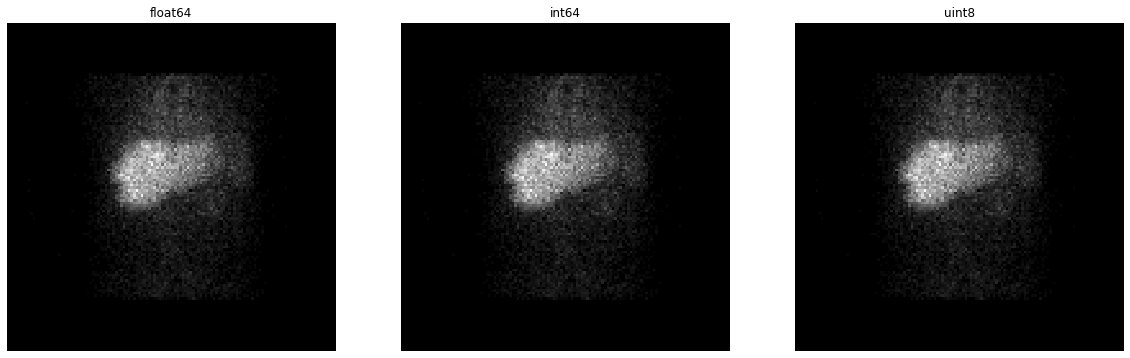

In [4]:
ant = pd.dcmread("Images/Dyn_Ant_HBS1.dcm")
post = pd.dcmread("Images/Dyn_Post_HBS1.dcm")
ant_pix = ant.pixel_array
post_pix = post.pixel_array[:,:,::-1]
mean = (ant_pix*post_pix)**(1/2)
for i in range(len(mean)):
    print(i, '\t', np.sum(ant_pix[i]), '\t', np.sum(post_pix[i]), '\t', round(np.sum(mean[i]),2))
print('Tot', '\t', np.sum(ant_pix), np.sum(post_pix), '', round(np.sum(mean),2))
    
print("Number of levels as {} =".format(mean.dtype), len(np.unique(mean)))

mean_int = np.rint(mean).astype(int)
#mean_int = mean / max(np.unique(mean))
#mean_int = 255 * mean_int
#mean_int = mean_int.astype(np.uint8)
print("Number of levels as {} =".format(mean_int.dtype), len(np.unique(mean_int)))

mean_norm = mean / max(np.unique(mean))
mean_norm = 255 * mean_norm
mean_norm = mean_norm.astype(np.uint8)
print("Number of levels as {} =".format(mean_norm.dtype), len(np.unique(mean_norm)))


plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.title(str(mean.dtype))
plt.axis('off')
plt.imshow(mean[25],cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title(str(mean_int.dtype))
plt.axis('off')
plt.imshow(mean_int[25],cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title(str(mean_norm.dtype))
plt.axis('off')
plt.imshow(mean_norm[25],cmap=plt.cm.gray)
plt.show()

68.70225614927067


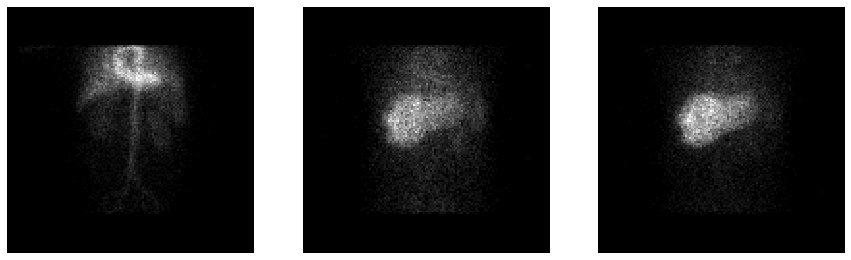

In [5]:
print(max(np.unique(mean)))
plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(mean[2,:,:],cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mean[20,:,:],cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mean[35,:,:],cmap=plt.cm.gray)
plt.show()

# Liver segmentation

(128, 128)
float64
Number of levels = 454
(128, 128)
float64
Number of levels = 4879
Number of levels as uint8 = 240


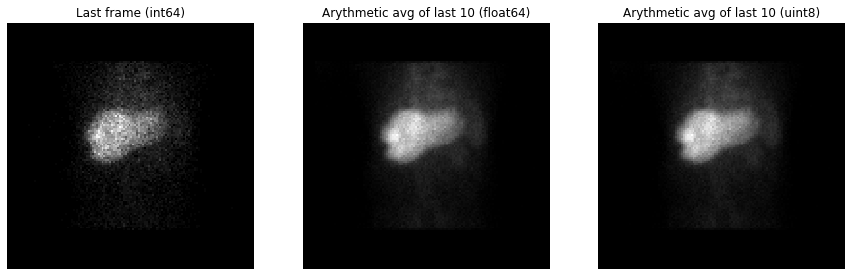

In [6]:
#Build avg of last 10

img = mean[35,:,:]
print(img.shape)
print(img.dtype)
print("Number of levels =", len(np.unique(img)))
img = img.astype(int)

avg = np.zeros(img.shape, dtype=np.float64)
for i in range(len(mean[-10:])):
    avg += mean[-i]
avg = avg/10
print(avg.shape)
print(avg.dtype)
print("Number of levels =", len(np.unique(avg)))

avg_norm = 255 * (avg / max(np.unique(avg)))
avg_norm = avg_norm.astype(np.uint8)
print("Number of levels as {} =".format(avg_norm.dtype), len(np.unique(avg_norm)))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Last frame ({})".format(img.dtype))
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg.dtype))
plt.imshow(avg, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg_norm.dtype))
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.show()

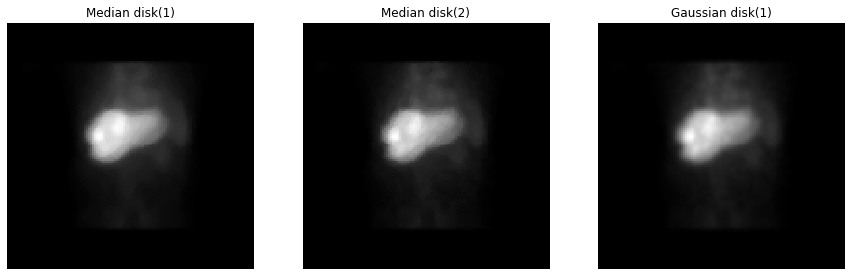

In [7]:
img_median = median(avg_norm, disk(3))
img_gauss = f64_2_u8(gaussian(avg_norm,1))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Median disk(1)")
plt.axis('off')
plt.imshow(img_median, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Median disk(2)")
plt.axis('off')
plt.imshow(median(avg_norm, disk(2)), cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Gaussian disk(1)")
plt.axis('off')
plt.imshow(img_gauss, cmap=plt.cm.gray)
plt.show()

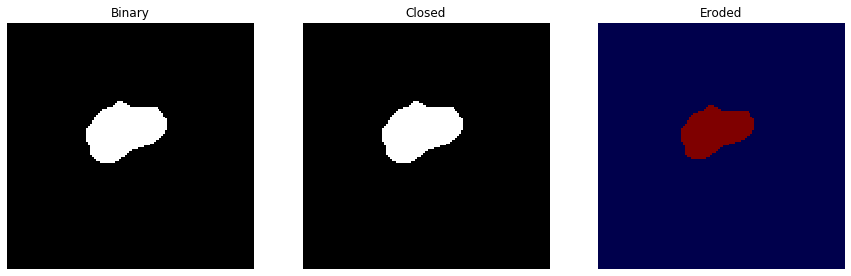

In [8]:
thresh = threshold_otsu(img_median)-10

binary = img_median > thresh
closed = closing(binary, disk(2))
eroded = erosion(binary, disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
plt.imshow(mean[35], cmap=plt.cm.gray)
plt.imshow(eroded, cmap='seismic')
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/_percentile.py:42: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


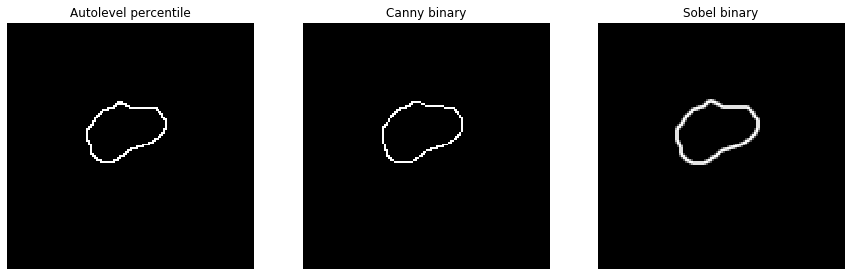

In [9]:
border = autolevel_percentile(binary,disk(2),p0=.1,p1=.9)

canny_binary = feature.canny(binary)
sobel_binary = sobel(binary)


plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentile")
plt.imshow(median(border, disk(1)), cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny binary")
plt.imshow(canny_binary, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel binary")
plt.imshow(sobel_binary, cmap=plt.cm.gray)
plt.show()

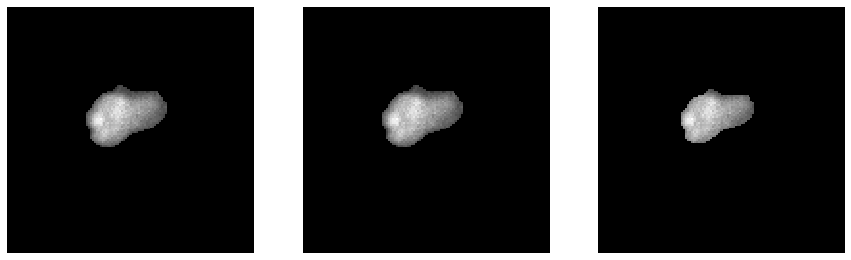

In [10]:
masked_img = avg_norm * binary
masked_closed = avg_norm * closed
masked_eroded = avg_norm * eroded

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(masked_img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(masked_closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(masked_eroded, cmap=plt.cm.gray)
plt.show()

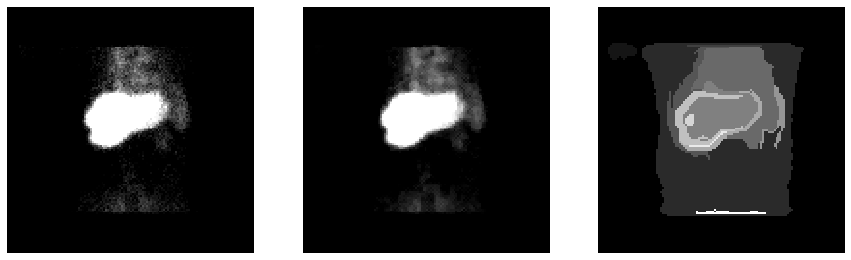

In [11]:
img_local1 = unsharp_mask(avg_norm, radius=20, amount=3)
img_local2 = unsharp_mask(median(avg_norm,disk(1)), radius=20, amount=3)
img_cluster = felzenszwalb(median(avg_norm, disk(2)), scale=100, sigma=0.5)

canny1 = feature.canny(img_local1, sigma=1)
canny2 = feature.canny(img_local2, sigma=1)


plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_local1, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img_local2, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(img_cluster, cmap=plt.cm.gray)
plt.show()

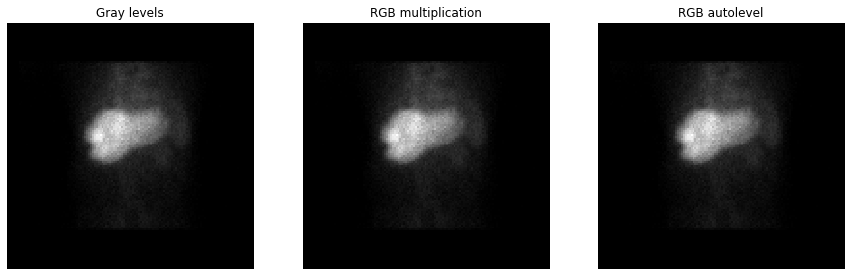

In [12]:
#RGB transform
img_rgb = gray2rgb(avg_norm)

#img_rgb2 = gray2rgb(np.rint(img_autolev).astype(int))
#print(np.unique(img_rgb2), len(np.unique(img_rgb2)))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Gray levels")
plt.axis('off')
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("RGB multiplication")
plt.axis('off')
plt.imshow(img_rgb)
plt.subplot(1,3,3)
plt.title("RGB autolevel")
plt.axis('off')
plt.imshow(img_rgb)
plt.show()

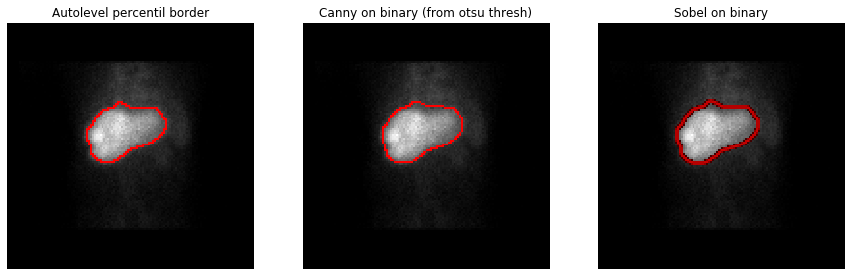

In [13]:
rgb_masked_bin = img_rgb.copy()
rgb_masked_auto = img_rgb.copy()
rgb_masked_so = img_rgb.copy()
for i in range(128):
    for j in range(128):
        if canny_binary[i,j]:
            rgb_masked_bin[i,j] = [255,0,0]
        if sobel_binary[i,j]:
            rgb_masked_so[i,j] = [sobel_binary[i,j]*255,0,0]
        if border[i,j]:
            rgb_masked_auto[i,j] = [255,0,0]

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentil border")
plt.imshow(rgb_masked_auto)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny on binary (from otsu thresh)")
plt.imshow(rgb_masked_bin)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel on binary")
plt.imshow(rgb_masked_so)
plt.show()

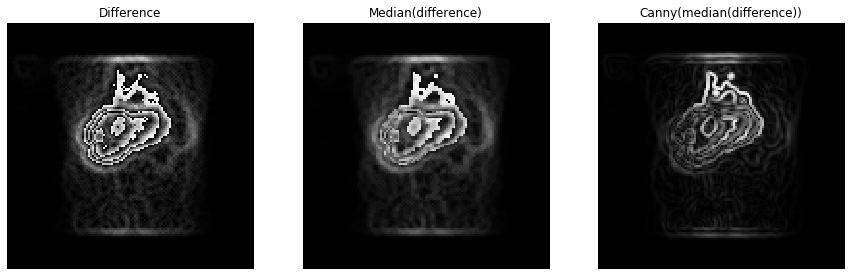

In [14]:
conv1 = convolve(avg_norm, disk(1))
conv2 = dilation(conv1, disk(3))
diff = conv2-conv1
diff_med = median(diff, disk(1))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Difference")
plt.imshow(diff, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Median(difference)")
plt.imshow(diff_med, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Canny(median(difference))")
plt.imshow(sobel(diff_med), cmap=plt.cm.gray)
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


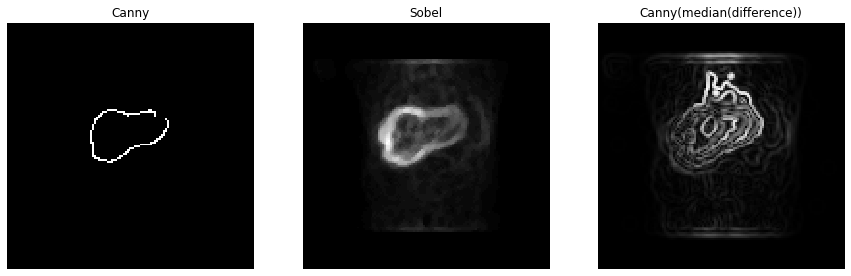

In [15]:
can = feature.canny(avg_norm, sigma=1.5, low_threshold=70, high_threshold=200)
sob = median(sobel(avg_norm),disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Canny")
plt.imshow(can, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Sobel")
plt.imshow(sob, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Canny(median(difference))")
plt.imshow(sobel(diff_med), cmap=plt.cm.gray)
plt.show()

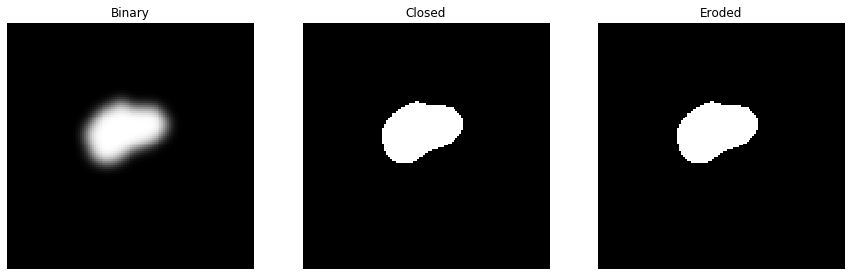

In [16]:
#binary edge smoohing
binary_gauss = gaussian(binary,3)
thresh_bis = threshold_otsu(binary_gauss)
binary_sm = binary_gauss > thresh_bis

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary_gauss, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.show()

# Blood pool segmentation

(128, 128)
Number of levels as uint8 = 222


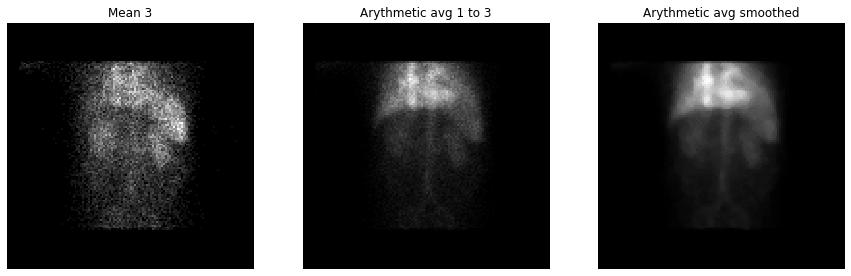

In [22]:
avg_blood = np.zeros(img.shape, dtype=np.float64)
for i in mean[1:5]:
    avg_blood += i
avg_blood = avg_blood/len(mean[1:5])
print(avg_blood.shape)

avg_blood_norm = 255 * (avg_blood / max(np.unique(avg_blood)))
avg_blood_norm = avg_blood_norm.astype(np.uint8)
print("Number of levels as {} =".format(avg_blood_norm.dtype), len(np.unique(avg_blood_norm)))

blood_med = median(avg_blood_norm, disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Mean 3")
plt.imshow(mean[3], cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 1 to 5")
plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg smoothed")
plt.imshow(blood_med, cmap=plt.cm.gray)
plt.show()

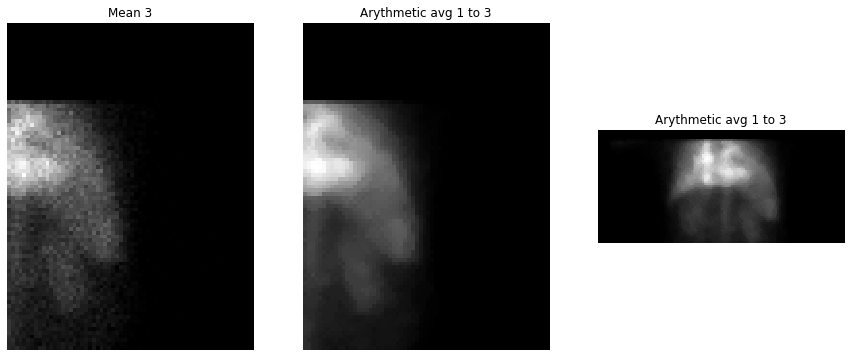

In [28]:
plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Mean 3")
plt.imshow(avg_blood_norm[:2*128//3,128//2:], cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(blood_med[:2*128//3,128//2:], cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(blood_med[15:128//2+10,:], cmap=plt.cm.gray)
plt.show()

In [106]:
def get_white(img):
    bin = np.full_like(img,1)
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i,j] >= 0.9:
                bin[i,j]=2
    return(bin)

def get_white_modif(img):
    bin = np.full_like(img,0)
    for i in range(len(img)):
        start = False
        end = False
        for j in range(len(img[i])):
            if (start or img[j,i] >= 0.95)and not end:
                start=True
                bin[j,i]=1
            if img[j,i] < 0.95 and start:
                end = True
    return(bin)

@interact(rad=IntSlider(min=0, max=50, step=1, value=15),  
          am=IntSlider(min=0, max=50, step=1, value=15))

def show_articles_more_than(rad=15, am=15):
    blood1 = unsharp_mask(avg_blood_norm, radius=rad, amount=am)
    blood2 = unsharp_mask(blood_med, radius=rad, amount=am)
    b_thresh = threshold_otsu(blood2)
    b_mask = blood2 > b_thresh
    
    s = np.linspace(0, 2*np.pi, 400)
    r = 35 + 20*np.sin(s)
    c = 70 + 30*np.cos(s)
    init = np.array([r, c]).T
    snake = active_contour(gaussian(blood2, 1),
                       init,coordinates='rc',beta=10)

    plt.figure(figsize=[15,15])
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Unsharp mask on avg")
    plt.imshow(blood1, cmap=plt.cm.gray)
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("Unsharp mask on median")
    plt.plot(init[:, 1], init[:, 0], '--r', lw=2)
    plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
    plt.imshow(blood2, cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("Binary")
    plt.imshow(closing(get_white_modif(blood2),disk(2)), cmap=plt.cm.gray)
    plt.show()

interactive(children=(IntSlider(value=15, description='rad', max=50), IntSlider(value=15, description='am', ma…

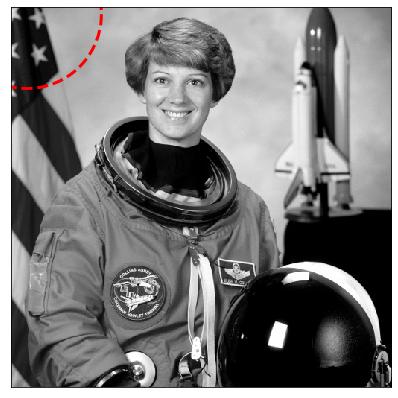

In [76]:
from skimage import data
from skimage.color import rgb2gray
from skimage.segmentation import active_contour


img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001,coordinates='rc')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

# Liver uptake rate calcul

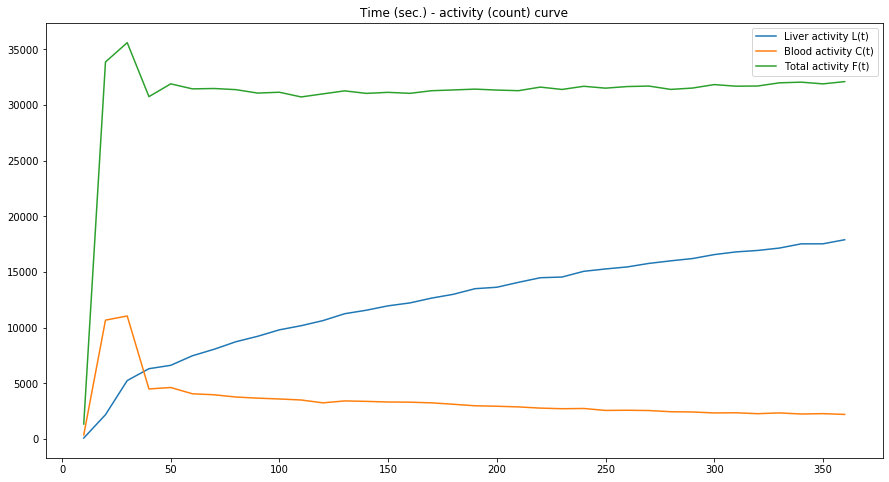

In [3]:
Lt = [75.22620206727042, 2171.6573873702037, 5240.058948964823, 6305.619571225982, 6607.721187184377, 
      7467.63367652685, 8053.170138852807, 8728.399722965907, 9216.42997469495, 9796.257192785464,
      10168.453806260755, 10624.295471130426, 11244.278590127613, 11559.879614734511, 11952.890712249471,
      12214.89474244861, 12648.103696731334, 12989.665926454853, 13493.978216861064, 13622.649235630475, 
      14066.917649478708, 14478.0181932679, 14542.018106621368, 15055.057892415993, 15266.997264601103, 
      15448.778303455118, 15767.03870079609, 15995.396593331285, 16200.973542529746, 16555.99972206792, 
      16799.543250210325, 16929.518449270337, 17144.46144060582, 17523.037645862783, 17525.437111308405, 
      17891.400293477927]

Ct = [351.7478164809896, 10668.544173216298, 11041.909114799568, 4484.668198489293, 4615.396316119048,
      4050.5709571712932, 3961.431601556106, 3758.899246596461, 3658.4869589222994, 3584.147897469105,
      3493.4851656959213, 3236.405206875266, 3409.554193212917, 3368.8555790379555, 3312.8815705198476,
      3296.167375905381, 3237.14336786035, 3109.0503908364, 2973.3958061535586, 2932.497745293502,
      2871.4733213814893, 2763.9361436574854, 2709.5256008464426, 2729.894468384449, 2556.0603424999467,
      2572.139191459586, 2546.353984364498, 2437.87357881079, 2415.9131966233995, 2329.807919957175,
      2345.0464706162034, 2261.6112781373927, 2332.7807017711716, 2233.532323806138, 2265.9857216221876,
      2197.9735204531275]

Ft = [1329.9157661663705, 33866.50767965961, 35597.35628606755, 30751.190575755667, 31898.107456356636,
      31447.3596818183, 31480.413591949604, 31377.319302048836, 31069.876190633655, 31145.344453515052,
      30722.75454881914, 30997.38099517003, 31268.679886806756, 31041.903015141776, 31135.78783291517,
      31045.77176539461, 31281.540568151828, 31352.083305213077, 31424.831097522976, 31339.79923302326,
      31285.354125446735, 31606.75220384242, 31395.846002779363, 31680.40515009864, 31511.89936071931,
      31656.517820026485, 31699.983655547407, 31399.58358705967, 31519.86707557144, 31831.91267752663,
      31688.262780412322, 31704.287466512564, 31990.330283461182, 32050.59106958875, 31896.500479975053,
      32100.04089303943]

time_steps = [10*(i+1) for i in range(36)]

plt.figure(figsize=[15,8])
plt.title('Time (sec.) - activity (count) curve')
plt.plot(time_steps, Lt, label = 'Liver activity L(t)')
plt.plot(time_steps, Ct, label = 'Blood activity C(t)')
plt.plot(time_steps, Ft, label = 'Total activity F(t)')
plt.legend()
plt.show()

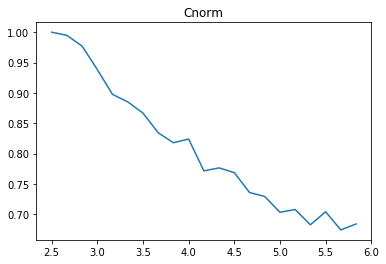

A(t1) : 21590.157510091896
Area under the curve : 2.688678306020769
Liver activity range : 5572.546399058934
Liver clearance rate : 9.59973%/min


In [12]:
def sec2min(sec):
    m = sec//60
    m += (sec%60)/60.0
    return(m)

Cnorm = np.array(Ct[14:35])/Ct[14]
plt.plot([sec2min(i) for i in time_steps[14:35]], Cnorm)
plt.title('Cnorm')
plt.show()

At1 = (Ft[34]-Lt[14]-(Ft[14]-Lt[14])*Cnorm[-1])/(1-Cnorm[-1]) #Ekman eq. 8
print('A(t1) :', At1)

integral = trapz(Cnorm, [sec2min(i) for i in time_steps[14:35]])
print('Area under the curve :', integral)

LClr = (Lt[34]-Lt[14])/(At1*integral) #Ekman eq. 4
print('Liver activity range :', Lt[34]-Lt[14])
print('Liver clearance rate : {:.5f}%/min'.format(LClr*100))

In [9]:
w = 64.0
h = 164
bsa = 0.024265*(w**(0.5378))*(h**(0.3964))     # Haycock
bsa = (h*w/3600)**(1/2)                        # Mosteller
corrected = LClr/bsa
print('Corrected uptake rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa, corrected*100))

Corrected uptake rate for BSA of 1.71m^2 : 5.62210%/min/m^2
